In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 24.4 MB/s eta 0:00:00


In [ ]:
# import os
# import shutil

# video_dir = "/content/drive/MyDrive/humor_detection/urfunny2_filtered_videos"
# text_src = "/content/drive/MyDrive/humor_detection/urfunny2_text_feature_pkl"
# audio_src = "/content/drive/MyDrive/humor_detection/urfunny2_audios_feature_pkl"
# text_dst = "/content/drive/MyDrive/humor_detection/urfunny2_1322_text_feature_pkl"
# audio_dst = "/content/drive/MyDrive/humor_detection/urfunny2_1322_audios_feature_pkl"

# os.makedirs(text_dst, exist_ok=True)
# os.makedirs(audio_dst, exist_ok=True)

# video_ids = set(os.path.splitext(f)[0] for f in os.listdir(video_dir) if f.endswith(".mp4"))

# count_text = 0
# for vid in video_ids:
#     src = os.path.join(text_src, f"{vid}.pkl")
#     dst = os.path.join(text_dst, f"{vid}.pkl")
#     if os.path.exists(src):
#         shutil.copyfile(src, dst)
#         count_text += 1

# count_audio = 0
# for vid in video_ids:
#     src = os.path.join(audio_src, f"{vid}.pkl")
#     dst = os.path.join(audio_dst, f"{vid}.pkl")
#     if os.path.exists(src):
#         shutil.copyfile(src, dst)
#         count_audio += 1

# print(f"Completed: text: {count_text}，audio: {count_audio}")


In [3]:
import os

visual_dir = "/content/drive/MyDrive/humor_detection/urfunny2_visual_pkl"
audio_dir = "/content/drive/MyDrive/humor_detection/urfunny2_1322_audios_feature_pkl"
text_dir = "/content/drive/MyDrive/humor_detection/urfunny2_1322_text_feature_pkl"

visual_ids = set(os.path.splitext(f)[0] for f in os.listdir(visual_dir) if f.endswith(".pkl"))
audio_ids = set(os.path.splitext(f)[0] for f in os.listdir(audio_dir) if f.endswith(".pkl"))
text_ids  = set(os.path.splitext(f)[0] for f in os.listdir(text_dir)  if f.endswith(".pkl"))

intersection = visual_ids & audio_ids & text_ids

print(f"Number of visual files: {len(visual_ids)}")
print(f"Number of audio files: {len(audio_ids)}")
print(f"Number of text files: {len(text_ids)}")
print(f"Number of files aligned across all modalities: {len(intersection)}")


Number of visual files: 1322
Number of audio files: 1322
Number of text files: 1322
Number of files aligned across all modalities: 1322


In [4]:

import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm

visual_dir = "/content/drive/MyDrive/humor_detection/urfunny2_visual_pkl"
audio_dir = "/content/drive/MyDrive/humor_detection/urfunny2_1322_audios_feature_pkl"
text_dir = "/content/drive/MyDrive/humor_detection/urfunny2_1322_text_feature_pkl"
label_path = "/content/drive/MyDrive/features/humor_label_sdk.pkl"

with open(label_path, "rb") as f:
    label_dict = pickle.load(f)

def safe_pool(x):
    if isinstance(x, torch.Tensor):
        x = x.cpu().numpy()
    x = np.array(x)
    while x.ndim > 2:
        x = np.squeeze(x, axis=0)
    if x.ndim == 2:
        x = np.mean(x, axis=0)
    return x

X_early, X_late, y_all = [], [], []

for fname in tqdm(sorted(os.listdir(visual_dir)), desc="Processing samples"):
    if not fname.endswith(".pkl"):
        continue
    try:
        vid = int(os.path.splitext(fname)[0])
        if vid not in label_dict:
            continue

        with open(os.path.join(visual_dir, f"{vid}.pkl"), "rb") as f:
            v_feat = pickle.load(f)
        with open(os.path.join(audio_dir, f"{vid}.pkl"), "rb") as f:
            a_feat = pickle.load(f)
        with open(os.path.join(text_dir, f"{vid}.pkl"), "rb") as f:
            t_feat = pickle.load(f)

        if isinstance(t_feat, dict):
            if 'punchline_embedding' in t_feat:
                t_feat = t_feat['punchline_embedding']
            else:
                raise ValueError(f"No punchline_embedding found in {fname}")

        for name, feat in zip(["visual", "audio", "text"], [v_feat, a_feat, t_feat]):
            if feat is None:
                raise ValueError(f"{name} is None")
            if not isinstance(feat, (np.ndarray, list, torch.Tensor)):
                raise ValueError(f"{name} is not array/list/tensor (got {type(feat)})")
            if len(feat) == 0:
                raise ValueError(f"{name} is empty")

        v = safe_pool(v_feat)
        a = safe_pool(a_feat)
        t = safe_pool(t_feat)

        X_early.append(np.concatenate([v, a, t]))
        X_late.append((v, a, t))
        y_all.append(label_dict[vid])

    except Exception as e:
        print(f" Skipping {fname}: {e}")




X_early = np.array(X_early)
X_late = np.array(X_late, dtype=object)
y_all = np.array(y_all)

X_e_train, X_e_temp, X_l_train, X_l_temp, y_train, y_temp = train_test_split(
    X_early, X_late, y_all, test_size=0.3, stratify=y_all, random_state=42)
X_e_val, X_e_test, X_l_val, X_l_test, y_val, y_test = train_test_split(
    X_e_temp, X_l_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# X_e_train, X_e_test, X_l_train, X_l_test, y_train, y_test = train_test_split(
#     X_early, X_late, y_all, test_size=0.10, stratify=y_all, random_state=42)

class EarlyFusionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

class LateFusionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        v, a, t = self.X[idx]
        return (torch.tensor(v, dtype=torch.float32),
                torch.tensor(a, dtype=torch.float32),
                torch.tensor(t, dtype=torch.float32)), self.y[idx]

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
    def forward(self, x): return self.net(x)

class LateFusionModel(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.v_proj = nn.Linear(dims[0], 64)
        self.a_proj = nn.Linear(dims[1], 64)
        self.t_proj = nn.Linear(dims[2], 64)
        self.fc = nn.Linear(64 * 3, 2)
    def forward(self, v, a, t):
        v, a, t = self.v_proj(v), self.a_proj(a), self.t_proj(t)
        x = torch.cat([v, a, t], dim=-1)
        return self.fc(x)

def train_model(model, train_loader, val_loader, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, 11):
        model.train()
        for batch in train_loader:
            xb, yb = batch if isinstance(batch, tuple) else (batch[0], batch[1])
            xb = [x.to(device) for x in xb] if isinstance(xb, (tuple, list)) else xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            output = model(*xb) if isinstance(xb, (tuple, list)) else model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()

def evaluate_model(model, loader, device):
    model.eval()
    preds, probs, labels = [], [], []
    with torch.no_grad():
        for batch in loader:
            xb, yb = batch if isinstance(batch, tuple) else (batch[0], batch[1])
            xb = [x.to(device) for x in xb] if isinstance(xb, (tuple, list)) else xb.to(device)
            logits = model(*xb) if isinstance(xb, (tuple, list)) else model(xb)
            probs.extend(F.softmax(logits, dim=1)[:, 1].cpu().numpy())
            preds.extend(logits.argmax(dim=1).cpu().numpy())
            labels.extend(yb.numpy())
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, probs)
    return acc, auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

early_model = MLP(X_early.shape[1]).to(device)
train_model(early_model,
            DataLoader(EarlyFusionDataset(X_e_train, y_train), batch_size=64, shuffle=True),
            DataLoader(EarlyFusionDataset(X_e_val, y_val), batch_size=64),
            device)
acc, auc = evaluate_model(early_model,
            DataLoader(EarlyFusionDataset(X_e_test, y_test), batch_size=64), device)
print(f" Early Fusion - Test Accuracy: {acc:.4f}, AUC: {auc:.4f}")

input_dims = (X_l_train[0][0].shape[0], X_l_train[0][1].shape[0], X_l_train[0][2].shape[0])
late_model = LateFusionModel(input_dims).to(device)
train_model(late_model,
            DataLoader(LateFusionDataset(X_l_train, y_train), batch_size=64, shuffle=True),
            DataLoader(LateFusionDataset(X_l_val, y_val), batch_size=64),
            device)
acc, auc = evaluate_model(late_model,
            DataLoader(LateFusionDataset(X_l_test, y_test), batch_size=64), device)
print(f" Late Fusion - Test Accuracy: {acc:.4f}, AUC: {auc:.4f}")


Processing samples: 100%|██████████| 1322/1322 [49:29<00:00,  2.25s/it]


 Early Fusion - Test Accuracy: 0.6935, AUC: 0.7555
 Late Fusion - Test Accuracy: 0.6985, AUC: 0.7518



 Training model 1/5
Epoch 1: Train Loss=0.6929 | Val AUC=0.6105


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 2: Train Loss=0.6911 | Val AUC=0.6089
Epoch 3: Train Loss=0.6894 | Val AUC=0.6136
Epoch 4: Train Loss=0.6876 | Val AUC=0.6160
Epoch 5: Train Loss=0.6844 | Val AUC=0.6241
Epoch 6: Train Loss=0.6800 | Val AUC=0.6269
Epoch 7: Train Loss=0.6722 | Val AUC=0.6331
Epoch 8: Train Loss=0.6626 | Val AUC=0.6418
Epoch 9: Train Loss=0.6488 | Val AUC=0.6453
Epoch 10: Train Loss=0.6329 | Val AUC=0.6535
Epoch 11: Train Loss=0.6135 | Val AUC=0.6557
Epoch 12: Train Loss=0.5847 | Val AUC=0.6655
Epoch 13: Train Loss=0.5648 | Val AUC=0.6640
Epoch 14: Train Loss=0.5370 | Val AUC=0.6682
Epoch 15: Train Loss=0.5135 | Val AUC=0.6722
Epoch 16: Train Loss=0.5073 | Val AUC=0.6698
Epoch 17: Train Loss=0.4753 | Val AUC=0.6690
Epoch 18: Train Loss=0.4759 | Val AUC=0.6685
Epoch 19: Train Loss=0.4567 | Val AUC=0.6718
Epoch 20: Train Loss=0.4312 | Val AUC=0.6722

 Training model 2/5
Epoch 1: Train Loss=0.6926 | Val AUC=0.5974


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 2: Train Loss=0.6907 | Val AUC=0.6200
Epoch 3: Train Loss=0.6883 | Val AUC=0.6373
Epoch 4: Train Loss=0.6860 | Val AUC=0.6448
Epoch 5: Train Loss=0.6824 | Val AUC=0.6421
Epoch 6: Train Loss=0.6766 | Val AUC=0.6515
Epoch 7: Train Loss=0.6682 | Val AUC=0.6517
Epoch 8: Train Loss=0.6592 | Val AUC=0.6575
Epoch 9: Train Loss=0.6452 | Val AUC=0.6577
Epoch 10: Train Loss=0.6248 | Val AUC=0.6599
Epoch 11: Train Loss=0.5979 | Val AUC=0.6677
Epoch 12: Train Loss=0.5690 | Val AUC=0.6679
Epoch 13: Train Loss=0.5476 | Val AUC=0.6721
Epoch 14: Train Loss=0.5280 | Val AUC=0.6706
Epoch 15: Train Loss=0.4985 | Val AUC=0.6726
Epoch 16: Train Loss=0.4786 | Val AUC=0.6691
Epoch 17: Train Loss=0.4617 | Val AUC=0.6707
Epoch 18: Train Loss=0.4510 | Val AUC=0.6709
Epoch 19: Train Loss=0.4333 | Val AUC=0.6714
Epoch 20: Train Loss=0.4183 | Val AUC=0.6728

 Training model 3/5
Epoch 1: Train Loss=0.6931 | Val AUC=0.5143


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 2: Train Loss=0.6916 | Val AUC=0.5500
Epoch 3: Train Loss=0.6899 | Val AUC=0.5706
Epoch 4: Train Loss=0.6879 | Val AUC=0.5920
Epoch 5: Train Loss=0.6850 | Val AUC=0.6037
Epoch 6: Train Loss=0.6806 | Val AUC=0.6098
Epoch 7: Train Loss=0.6760 | Val AUC=0.6217
Epoch 8: Train Loss=0.6657 | Val AUC=0.6275
Epoch 9: Train Loss=0.6532 | Val AUC=0.6366
Epoch 10: Train Loss=0.6344 | Val AUC=0.6425
Epoch 11: Train Loss=0.6143 | Val AUC=0.6475
Epoch 12: Train Loss=0.5851 | Val AUC=0.6503
Epoch 13: Train Loss=0.5648 | Val AUC=0.6537
Epoch 14: Train Loss=0.5412 | Val AUC=0.6597
Epoch 15: Train Loss=0.5224 | Val AUC=0.6616
Epoch 16: Train Loss=0.5164 | Val AUC=0.6587
Epoch 17: Train Loss=0.4902 | Val AUC=0.6634
Epoch 18: Train Loss=0.4633 | Val AUC=0.6650
Epoch 19: Train Loss=0.4503 | Val AUC=0.6635
Epoch 20: Train Loss=0.4241 | Val AUC=0.6645

 Training model 4/5
Epoch 1: Train Loss=0.6929 | Val AUC=0.5803


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 2: Train Loss=0.6916 | Val AUC=0.6039
Epoch 3: Train Loss=0.6896 | Val AUC=0.6192
Epoch 4: Train Loss=0.6876 | Val AUC=0.6196
Epoch 5: Train Loss=0.6850 | Val AUC=0.6284
Epoch 6: Train Loss=0.6805 | Val AUC=0.6395
Epoch 7: Train Loss=0.6741 | Val AUC=0.6380
Epoch 8: Train Loss=0.6655 | Val AUC=0.6434
Epoch 9: Train Loss=0.6521 | Val AUC=0.6512
Epoch 10: Train Loss=0.6369 | Val AUC=0.6565
Epoch 11: Train Loss=0.6136 | Val AUC=0.6601
Epoch 12: Train Loss=0.5932 | Val AUC=0.6615
Epoch 13: Train Loss=0.5652 | Val AUC=0.6641
Epoch 14: Train Loss=0.5427 | Val AUC=0.6676
Epoch 15: Train Loss=0.5181 | Val AUC=0.6664
Epoch 16: Train Loss=0.4999 | Val AUC=0.6663
Epoch 17: Train Loss=0.4937 | Val AUC=0.6682
Epoch 18: Train Loss=0.4614 | Val AUC=0.6669
Epoch 19: Train Loss=0.4468 | Val AUC=0.6674
Epoch 20: Train Loss=0.4298 | Val AUC=0.6645

 Training model 5/5
Epoch 1: Train Loss=0.6933 | Val AUC=0.5172


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 2: Train Loss=0.6917 | Val AUC=0.5500
Epoch 3: Train Loss=0.6900 | Val AUC=0.5684
Epoch 4: Train Loss=0.6879 | Val AUC=0.5846
Epoch 5: Train Loss=0.6853 | Val AUC=0.5968
Epoch 6: Train Loss=0.6802 | Val AUC=0.6066
Epoch 7: Train Loss=0.6737 | Val AUC=0.6191
Epoch 8: Train Loss=0.6624 | Val AUC=0.6291
Epoch 9: Train Loss=0.6482 | Val AUC=0.6354
Epoch 10: Train Loss=0.6289 | Val AUC=0.6426
Epoch 11: Train Loss=0.6042 | Val AUC=0.6447
Epoch 12: Train Loss=0.5832 | Val AUC=0.6488
Epoch 13: Train Loss=0.5591 | Val AUC=0.6534
Epoch 14: Train Loss=0.5396 | Val AUC=0.6551
Epoch 15: Train Loss=0.5213 | Val AUC=0.6563
Epoch 16: Train Loss=0.5004 | Val AUC=0.6585
Epoch 17: Train Loss=0.4813 | Val AUC=0.6595
Epoch 18: Train Loss=0.4751 | Val AUC=0.6614
Epoch 19: Train Loss=0.4477 | Val AUC=0.6603
Epoch 20: Train Loss=0.4227 | Val AUC=0.6597

 Final Cross-Modal MoE++ Ensemble Test Results:
   Best Threshold: 0.364
   Test Accuracy: 0.7387
   Test ROC AUC: 0.7749


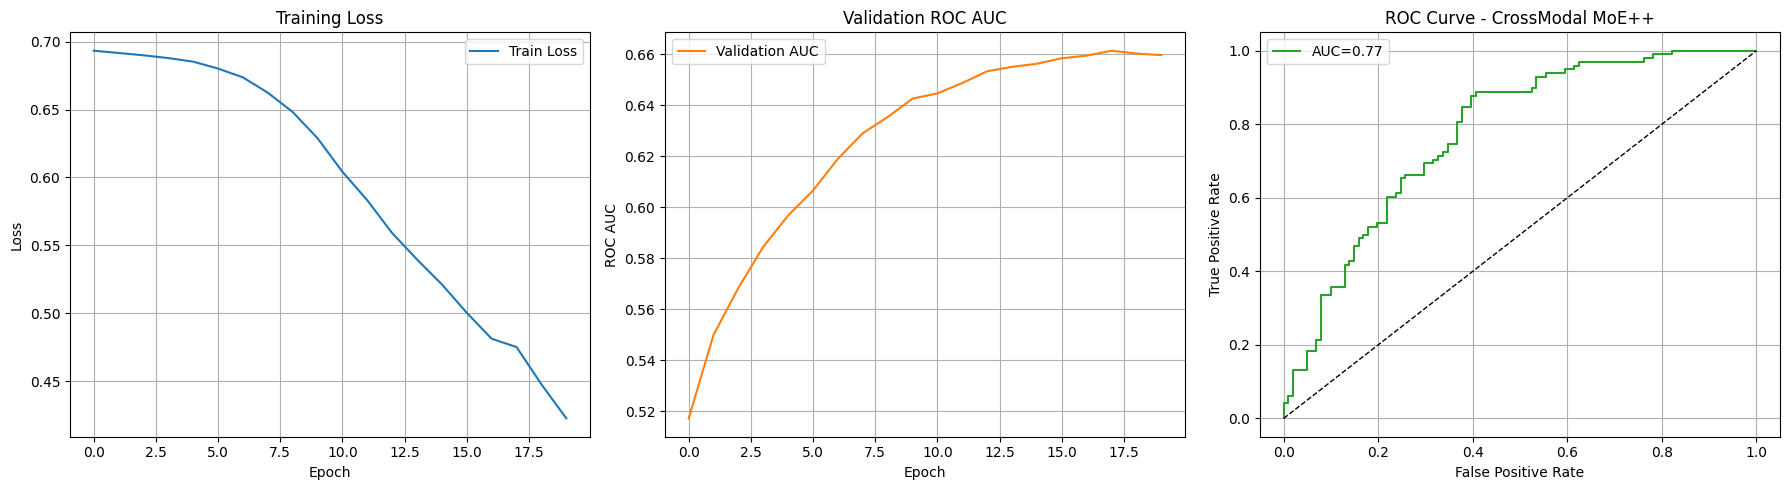

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# --- Model Definitions ---
class CrossModalFusionPlusBoosted(nn.Module):
    def __init__(self, dim_visual, dim_audio, dim_text, output_dim=128):
        super().__init__()
        self.visual_proj = nn.Linear(dim_visual, output_dim)
        self.audio_proj = nn.Linear(dim_audio, output_dim)
        self.text_proj = nn.Linear(dim_text, output_dim)

        self.v_to_va = nn.Sequential(nn.Linear(output_dim, output_dim), nn.ReLU())
        self.a_to_va = nn.Sequential(nn.Linear(output_dim, output_dim), nn.ReLU())
        self.v_to_vt = nn.Sequential(nn.Linear(output_dim, output_dim), nn.ReLU())
        self.t_to_vt = nn.Sequential(nn.Linear(output_dim, output_dim), nn.ReLU())
        self.a_to_at = nn.Sequential(nn.Linear(output_dim, output_dim), nn.ReLU())
        self.t_to_at = nn.Sequential(nn.Linear(output_dim, output_dim), nn.ReLU())

        self.fusion_proj = nn.Linear(output_dim * 6, output_dim)

    def forward(self, v, a, t):
        v_proj = self.visual_proj(v)
        a_proj = self.audio_proj(a)
        t_proj = self.text_proj(t)

        va = self.v_to_va(v_proj) * self.a_to_va(a_proj)
        vt = self.v_to_vt(v_proj) * self.t_to_vt(t_proj)
        at = self.a_to_at(a_proj) * self.t_to_at(t_proj)

        concat = torch.cat([v_proj, a_proj, t_proj], dim=-1)
        fused = torch.cat([concat, va, vt, at], dim=-1)
        fused = self.fusion_proj(fused)
        return fused

class MoE(nn.Module):
    def __init__(self, input_dim, num_experts=6, hidden_dim=128):
        super().__init__()
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, 2)
            ) for _ in range(num_experts)
        ])

        self.gating = nn.Sequential(
            nn.Linear(input_dim, num_experts),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        gates = self.gating(x)
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
        out = torch.einsum('bn,bnc->bc', gates, expert_outputs)
        return out

class CrossModalMoEModelPlus(nn.Module):
    def __init__(self, dims, output_dim=128, num_experts=6, hidden_dim=128):
        super().__init__()
        self.fusion = CrossModalFusionPlusBoosted(*dims, output_dim=output_dim)
        self.moe = MoE(input_dim=output_dim, num_experts=num_experts, hidden_dim=hidden_dim)

    def forward(self, v, a, t):
        fused = self.fusion(v, a, t)
        out = self.moe(fused)
        return out

# --- Training Model ---
def train_with_val(model, train_loader, val_loader, device, epochs=20):
    optimizer = torch.optim.AdamW(model.parameters(), lr=4e-5, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=False)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_aucs = [], []
    best_val_auc = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            xb, yb = batch
            xb = [x.to(device) for x in xb]
            yb = yb.to(device)

            optimizer.zero_grad()
            output = model(*xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        preds, probs, labels = evaluate_model(model, val_loader, device)
        val_auc = roc_auc_score(labels, probs)
        scheduler.step(val_auc)
        val_aucs.append(val_auc)

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model_state = model.state_dict()

        print(f"Epoch {epoch+1}: Train Loss={avg_loss:.4f} | Val AUC={val_auc:.4f}")

    model.load_state_dict(best_model_state)
    return train_losses, val_aucs, model

def evaluate_model(model, loader, device):
    model.eval()
    preds, probs, labels = [], [], []
    with torch.no_grad():
        for batch in loader:
            xb, yb = batch
            xb = [x.to(device) for x in xb]
            logits = model(*xb)
            probs.extend(F.softmax(logits, dim=1)[:, 1].cpu().numpy())
            preds.extend(logits.argmax(dim=1).cpu().numpy())
            labels.extend(yb.numpy())
    return np.array(preds), np.array(probs), np.array(labels)

def find_best_threshold(y_true, y_probs):
    best_thresh, best_acc = 0.5, 0
    thresholds = np.linspace(0.3, 0.7, 101)
    for thresh in thresholds:
        preds = (y_probs >= thresh).astype(int)
        acc = accuracy_score(y_true, preds)
        if acc > best_acc:
            best_acc = acc
            best_thresh = thresh
    return best_thresh, best_acc

# --- Train Ensemble Models ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dims = (X_l_train[0][0].shape[0], X_l_train[0][1].shape[0], X_l_train[0][2].shape[0])

train_loader = DataLoader(LateFusionDataset(X_l_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(LateFusionDataset(X_l_val, y_val), batch_size=64)
test_loader = DataLoader(LateFusionDataset(X_l_test, y_test), batch_size=64)

n_ensemble = 5
ensemble_models = []

for seed in range(n_ensemble):
    torch.manual_seed(seed)
    model = CrossModalMoEModelPlus(dims=input_dims, output_dim=128, num_experts=6, hidden_dim=258).to(device)

    print(f"\n Training model {seed+1}/{n_ensemble}")
    train_losses, val_aucs, trained_model = train_with_val(model, train_loader, val_loader, device, epochs=20)

    ensemble_models.append(trained_model)

# --- Evaluate Ensemble ---
all_probs = []
for model in ensemble_models:
    _, probs, _ = evaluate_model(model, test_loader, device)
    all_probs.append(probs)

avg_probs = np.mean(all_probs, axis=0)

best_thresh, _ = find_best_threshold(y_test, avg_probs)
final_preds = (avg_probs >= best_thresh).astype(int)

test_acc = accuracy_score(y_test, final_preds)
test_auc = roc_auc_score(y_test, avg_probs)

print(f"\n Final Cross-Modal MoE++ Ensemble Test Results:")
print(f"   Best Threshold: {best_thresh:.3f}")
print(f"   Test Accuracy: {test_acc:.4f}")
print(f"   Test ROC AUC: {test_auc:.4f}")

# --- Plotting Summary Metrics ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(train_losses, label='Train Loss', color='tab:blue')
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid()
axes[0].legend()

axes[1].plot(val_aucs, label='Validation AUC', color='tab:orange')
axes[1].set_title('Validation ROC AUC')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('ROC AUC')
axes[1].grid()
axes[1].legend()

fpr, tpr, _ = roc_curve(y_test, avg_probs)
roc_auc = auc(fpr, tpr)
axes[2].plot(fpr, tpr, label=f"AUC={roc_auc:.2f}", color='tab:green')
axes[2].plot([0, 1], [0, 1], 'k--', lw=1)
axes[2].set_title('ROC Curve - CrossModal MoE++')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].grid()
axes[2].legend()

plt.tight_layout()
plt.show()